In [3]:
#!pip install biopython
import sys, os, copy, pprint, glob
#import pathlib
from importlib import reload
import pathlib, importlib
import csv, fnmatch, random
import Bio.Entrez #used by accessions_to_gb
from ftplib import FTP
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pyfastx

## Import UniProt:  
Download One protein per gene
https://www.uniprot.org/proteomes/UP000005640

In [4]:
huprot_path="data/UP000005640_9606.fasta"
fa_file = pyfastx.Fasta(huprot_path)
fa_file

<Fasta> data/UP000005640_9606.fasta contains 20605 sequences

## Protein Digestion:  

https://pyopenms.readthedocs.io/en/latest/installation.html  

https://readthedocs.org/projects/pyopenms/downloads/pdf/release_2.4.0/


Protease/Chemical Digestion  

MassSpec, is ideally suited to detect protein fragmentation products, since it detects thousands of fragments at a time, but under the conditions of our assay, we need to be able to detect every digestion product in our sample, because if we can’t then those extra fragments can quickly fill up our sample locations with undecypherable species. Furthermore, since not all protein digestions can be counted on to proceed to completion, there may be partially digested species that can confuse, though probably not completely confound detection.  I surveyed the 30 available proteases included in the pyopenms package. While most generate millions of very small fragments when applied to Uniprot, a few (Asp-N and CNBr, Fig. 2) generate fragments that are between 50 to 200 residues that still have representation for 16 of 22k Uniprot sequences, but even under this best case scenario, we would still need to predict and make available probes that can discriminate (for CNBR) 19060 proteins * 3.8 avg fragments. This may be possible and the tools developed in this study can be used to determine how easily these fragments can be detected. A combination of size fractionation, and partition by charge or hydrophobicity can generate reproducible sample preparations.  
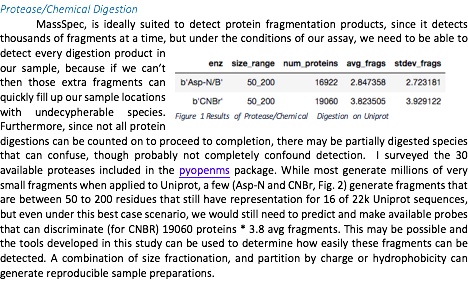

In [5]:
from pyopenms import *

p=ProteaseDB()
n=[]
p.getAllNames(n)

def digest(enz, fa_file, rngLst=[0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000]):
    dig.setEnzyme(enz)
    size_dict={}
    fa = pyfastx.Fasta(huprot_path)
    oLst=[]
    for seq in fa_file:
        result = []
        s=seq.seq;name=seq.name;
        prefix, acc=name.split('|')[0:2]
        if prefix=='tr':continue
        dig.digest(AASequence.fromString(s), result)
        result=[r.toString() for r in result]
        print(name, len(result), end='\r')
        for i in range(len(rngLst)-1):
            min_sz=rngLst[i];max_sz=rngLst[i+1]
            mami='%i_%i'%(min_sz, max_sz)
            if not(mami in size_dict):size_dict[mami]={}
            l=list(filter(lambda x:min_sz<=len(x)<max_sz, result))
            if l:
                size_dict[mami][acc]=l
    return size_dict

In [6]:
huprot_path="/tdata2/human_proteome/UP000005640_9606.fasta"

dig = ProteaseDigestion()
oLst=[];LL=['enz', 'size_range', 'num_proteins', 'avg_frags', 'stdev_frags']

enz_names=[
    b'Trypsin',
         b'Clostripain/P',
         b'Glu-C+P',
         b'TrypChymo',
         b'Arg-C/P',
         b'V8-E',
         b'Chymotrypsin',
         b'elastase-trypsin-chymotrypsin',
         b'staphylococcal protease/D',
         b'Trypsin/P',
         #b'unspecific cleavage',
         b'Chymotrypsin/P',
         b'proline-endopeptidase/HKR',
         b'PepsinA + P',
         b'cyanogen-bromide',
         #b'CNBr',
         b'V8-DE',
         b'Lys-C/P',
         b'leukocyte elastase',
         b'proline endopeptidase',
         b'glutamyl endopeptidase',
         b'Alpha-lytic protease',
         b'2-iodobenzoate',
         b'iodosobenzoate',
         b'Arg-C',
         b'Asp-N/B',
         b'Lys-C',
         b'PepsinA',
         b'Asp-N_ambic',
         b'Lys-N',
         b'Formic_acid',
         b'Asp-N',
         #b'no cleavage'
          ]

enz_names=[
    b'Asp-N/B',b'CNBr',b'Arg-C',b'Formic_acid',
]
#p.getAllNames(enz_names)
rngLst=[50, 200]#[0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000])
for enz in enz_names:
    print(enz)
    dig.setEnzyme(enz)
    size_dict=digest(enz, fa_file, rngLst=rngLst)
    for i in range(len(rngLst)-1):
        min_sz=rngLst[i];max_sz=rngLst[i+1]
        mami='%i_%i'%(min_sz, max_sz)
        clst = np.array([len(size_dict[mami][k]) for k in size_dict[mami].keys()])
        oLst.append([enz, mami, len(size_dict[mami]), clst.mean(), clst.std()])
df = pd.DataFrame(oLst, columns=LL)
enz_str=str(enz).replace(' ','').replace('/', '-').replace('+','plus').replace("'", '')[1:]
#df.to_csv('all_digestions50-200.csv')
df

b'Asp-N/B'
b'CNBr'81|PYDC5_HUMAN 73011532 30421135 26 1610 29301716026 24227 1621 2154 412499 15 98104 631371617 99131121
b'Arg-C'1|PYDC5_HUMAN 310 727116 210 93 155 11124 721 103 1014 2729 78 2247 6 417 15 826 11
b'Formic_acid'5_HUMAN 7176187 420142 15127 7938 2429 6031 4714 217 491 226 16 36 14 2412 515 13 2760 1120 38 33 2810


,enz,size_range,num_proteins,avg_frags,stdev_frags
0,b'Asp-N/B',50_200,16922,2.847358,2.723181
1,b'CNBr',50_200,19060,3.823505,3.929122
2,b'Arg-C',50_200,15795,2.896106,3.256245
3,b'Formic_acid',50_200,16709,2.767730,2.630536


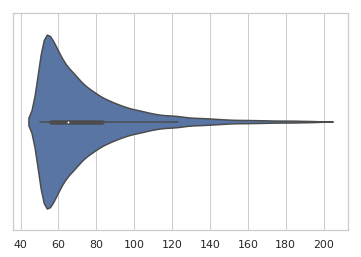

In [7]:
import seaborn as sns

fragLst=[]
for k in size_dict[mami].keys():
    fragLst.extend([len(x) for x in size_dict[mami][k]])
sns.set(style="whitegrid")
ax = sns.violinplot(x=fragLst)